In [12]:
# @title Update the system and install libraries
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [2]:
# @title Install dependencies
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed buildi

In [3]:
import io
import os
import glob
import torch
import base64
import numpy as np
import matplotlib.pyplot as plt
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [4]:
# @title Play Video function
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [5]:
nn_layers = [64, 64]  # This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                      # If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001  # This is the step-size with which the gradient descent is carried out.
                       # Tip: Use smaller step-sizes for larger networks.

In [6]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name = 'LunarLander-v2'
env = gym.make(env_name)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  # for simplicity, we are not doing batch update.
            buffer_size=1,  # size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=1,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = 1,  # initial value of random action probability
            exploration_fraction = 0.5,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

In [7]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [8]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_pretraining.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -697.8056694821321


In [9]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)

Eval num_timesteps=10000, episode_reward=-368.77 +/- 110.31
Episode length: 174.20 +/- 39.29
New best mean reward!
Eval num_timesteps=20000, episode_reward=-132.38 +/- 17.62
Episode length: 395.40 +/- 303.54
New best mean reward!
Eval num_timesteps=30000, episode_reward=-16.11 +/- 17.10
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-121.70 +/- 36.19
Episode length: 67.20 +/- 6.11
Eval num_timesteps=50000, episode_reward=-79.89 +/- 38.60
Episode length: 533.80 +/- 381.52
Eval num_timesteps=60000, episode_reward=-12.70 +/- 21.42
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=70000, episode_reward=-37.01 +/- 58.44
Episode length: 966.80 +/- 66.40
Eval num_timesteps=80000, episode_reward=-49.99 +/- 27.82
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=-31.48 +/- 73.33
Episode length: 794.80 +/- 324.27
Eval num_timesteps=100000, episode_reward=-69.70 +/- 32.78
Episode length: 835.40 +/- 32

In [10]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(



Total reward: -233.72803849086594


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


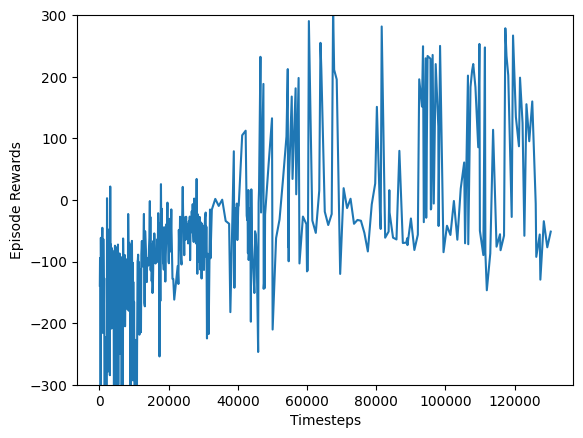

In [11]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()